<hr style="border-width:4px; border-style:solid; border-color:coral"></hr>

# MPI_Gather

<hr style="border-width:4px; border-style:solid; border-color:coral"></hr>

The function `P

In [24]:
%%file gather_bug.c

#include <mpi.h>
#include <math.h>

#include <stdio.h>
#include <stdlib.h>

/* Initial condition */
double init(double x)
{
    return exp(-5*x*x);;
}

int main(int argc, char** argv)
{
    MPI_Init(&argc, &argv);

    int rank, nprocs;
    MPI_Comm_rank(MPI_COMM_WORLD, &rank);
    MPI_Comm_size(MPI_COMM_WORLD, &nprocs);


    /* ------------------------------------ User input ---------------------------------*/
    int N = atoi(argv[1]);

    double a = -1;
    double b = 1;

    /* ------------------------------- Numerical parameters ----------------------------*/

    double Nlocal = N/nprocs;
    double w = (b-a)/nprocs;

    double dx = (b-a)/N;
    double dx2 = dx*dx;

    /* Initialize data */
    double *const qmem = (double*) malloc((Nlocal+3)*sizeof(double));
    double *const q = &qmem[1];

    /* --------------------------------- Initialize data -------------------------------*/

    for(int i = -1; i <= Nlocal+1; i++)
    {
        double x = a + rank*w + i*dx;
        q[i] = init(x);        
    }

    /* ----------------------------- Write data to a file  -----------------------------*/

    int node0 = 0;
    FILE *fout;
    double *qbig;
    int *recvcounts;
    int *displs;

    /* Write out meta-data */
    if (rank == 0)
    {
        fout = fopen("gather.out","w");
        fwrite(&N,1,sizeof(int),fout);
        fwrite(&a,1,sizeof(double),fout);
        fwrite(&b,1,sizeof(double),fout);

        qbig = (double*) malloc((N+3)*sizeof(double));

        recvcounts = malloc(nprocs*sizeof(int));
        displs = malloc(nprocs*sizeof(int));

        for(int p = 0; p < nprocs; p++)
        {
            displs[p] = p*Nlocal;
            recvcounts[p] = Nlocal+1;
        }

    }

    MPI_Gatherv(&q[0],Nlocal+1,MPI_DOUBLE,
                qbig,recvcounts,displs,MPI_DOUBLE,
                node0,MPI_COMM_WORLD);        

    if (rank == 0)
    {
        fwrite(qbig,N+1,sizeof(double),fout);
        free(qbig);
        fclose(fout);
    }
    free(qmem);
    
    MPI_Finalize();
}


Overwriting gather_bug.c


In [25]:
%%bash

# Usage :  
#
#    $ gather <N> <gather_choice>
#
# where <N> is the number of mesh cells and <gather_choice> is 0 to use 'gather' and 
# 1 to use 'gatherv'

rm -rf gather_bug.o gather

mpicc -o gather ./gather_bug.c -lm

mpirun -n 4 ./gather 32

In [26]:
import numpy as np
import matplotlib.pyplot as plt

# Open file for reading; use binary mode
fout = open("gather.out","rb")

# Read meta data
dt_meta = np.dtype([('N','int32'),('a','d'),('b','d')])
d = np.fromfile(fout,dtype=dt_meta, count=1)[0]

# create dictionary containing meta data
parms = dict(zip(dt_meta.fields,d))

# Print meta data from dictionary
print("N = {N:d}\n".format(**parms))

# Assign values in tuple directly (for use below)
N,a,b = d

# Read solution data
dt_q = np.dtype([('q','d',N+1)])  
data = np.fromfile(fout,dtype=dt_q)

# Close file
fout.close()

N = 32



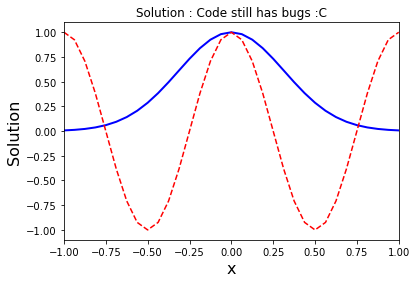

In [27]:
fig = plt.figure(1)
plt.clf()

q = data[0][0]

x = np.linspace(a,b,N+1)

err = abs(q-np.cos(2*np.pi*x)).max()

if abs(err) < 1e-15:
    estr = 'You found all the bugs C:'
else:
    estr = 'Code still has bugs :C'


htitle = plt.title('Solution : {:s}'.format(estr) )

plt.plot(x,q,linewidth=2,color='b')
plt.plot(x,np.cos(2*np.pi*x),'r--')

plt.xlabel('x',fontsize=16)
plt.ylabel('Solution',fontsize=16)
plt.xlim([a,b])

fig.canvas.draw()  